# How Convolution layer works?


- 기수: 13

- 이름: 백승이

- 작성자: 13기 강승우

압축을 해제한 폴더 그대로 경로 변경 없이 문제를 푸시면됩니다.  
**CNN assignment폴더 아래에 data폴더, CNN 노트북파일, 이미지파일이 위치해야합니다.**  
문제가 생길 경우 경로 코드를 수정하시거나, 학술부에게 문의해주세요

이번 문제에서는 직접 Convolution 연산을 구현해보며 CNN의 동작 원리를 알아보고자 합니다.

**목표**
- `nn.Conv2d`와 동일한 연산을 **NumPy로 직접 구현**
- laplacian filter와 sobel filter를 **이미지에 적용**

**라이브러리 및 함수 정의**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import Tuple, Optional

# 시각화 유틸
def show_gray(img, title=None):
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

def minmax_norm(x: np.ndarray, eps: float = 1e-12):
    mn, mx = np.min(x), np.max(x)
    if mx - mn < eps:
        return np.zeros_like(x)
    return (x - mn) / (mx - mn)

**이미지 준비**

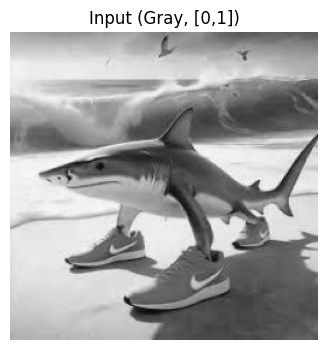

In [4]:
def load_image(path: Optional[str] = None, size: Tuple[int,int]=(256,256)) -> np.ndarray:
    img = Image.open(path).convert('L').resize(size, Image.BILINEAR)
    arr = np.array(img, dtype=np.float32) / 255.0
    return arr

# 사용 예시: path=None -> 합성 이미지
img = load_image(path="/content/drive/MyDrive/DSL-2/[0902]CNN_FirstnameLASTNAME/Code assignment/Code assignment/tralla.jpg", size=(256,256))
show_gray(img, title='Input (Gray, [0,1])')

**Q1. numpy를 사용하여 이미지와 커널 배열을 입력으로 받는 conv2D_naive 함수를 구현하세요**

In [5]:
def conv2d_naive(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    image: (H, W)
    kernel: (kH, kW)

    반환: (outH, outW)
    """
    # padding=0, stride=1 조건으로 구현
    padding = 0
    padded = np.pad(image, ((padding, padding), (padding, padding)), mode='constant')
    stride = 1

    H, W   = image.shape
    kH, kW = kernel.shape
    outH = H - kH + 1  # padding=0, stride=1
    outW = W - kW + 1
    out  = np.zeros((outH, outW), dtype=np.float32)

    k = kernel[::-1, ::-1]  # (true) convolution: flip kernel

    for i in range(outH):
        for j in range(outW):
            patch = padded[i:i+kH, j:j+kW]
            out[i, j] = np.sum(patch * k)

    ##########
    return out


**Q2. 작성한 코드의 동작 방식이 왜 CNN의 convolution 연산과 동일한지 아래 마크다운에 자세히 설명해주세요. (예시를 들어 설명하셔도 좋습니다)**

슬라이딩 윈도우로 이미지를 훑으면서 커널과 패치의 원소별 dot product을 계산하고 이 값을 모아 feature map을 만드는 방식이다. 즉 CNN의 합성곱 층이 하는 일과 똑같은 계산을(Conv2d: stride=1, padding=0 설정)코드로 구현한 거라 convolution 연산과 동일하다고 할 수 있다.

**라플라시안 필터 적용 및 시각화**


- Laplace Filter  
\begin{bmatrix}
1 & 1 & 1\\
1 & -8 & 1\\
1 & 1 & 1
\end{bmatrix}

- Sobel Filter(수직)  
\begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix}

- Sobel Filter(수평)
\begin{bmatrix}
-1 & -2 & -1\\
0 & 0 & 0\\
1 & 2 & 1
\end{bmatrix}


In [6]:
laplace = np.array([[ 1, 1, 1],
                    [ 1,-8, 1],
                    [ 1, 1, 1]], dtype=np.float32)

sobel_vertical = np.array([[ -1, 0, 1],
                           [ -2, 0, 2],
                           [ -1, 0, 1]], dtype=np.float32)

sobel_horizontal = np.array([[ -1, -2, -1],
                             [  0,  0,  0],
                             [  1,  2,  2]], dtype=np.float32)

print('laplace:\n', laplace)
print('sobel_vertical\n', sobel_vertical)
print('sobel_horizontal:\n', sobel_horizontal)

laplace:
 [[ 1.  1.  1.]
 [ 1. -8.  1.]
 [ 1.  1.  1.]]
sobel_vertical
 [[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]]
sobel_horizontal:
 [[-1. -2. -1.]
 [ 0.  0.  0.]
 [ 1.  2.  2.]]


**구현한 Conv함수와 주어진 filter로 이미지의 edge를 검출해보세요**
- 결과의 범위가 음수가 될 수 있어, 시각화를 위해 정규화 사용

In [7]:
def apply_filter_and_visualize(img: np.ndarray, kernel: np.ndarray, stride: int = 1):

    resp = conv2d_naive(img, kernel)
    resp_signed = minmax_norm(resp)      # [-?, +?] -> [0,1] 정규화

    show_gray(img, 'Input')
    show_gray(resp_signed, 'Laplacian response (signed → min-max normalized)')
    return resp

=== Laplacian ===


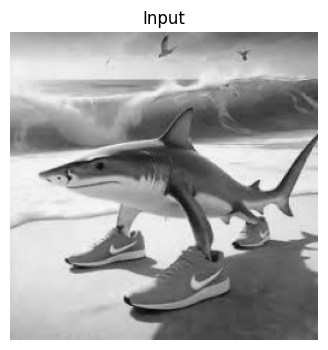

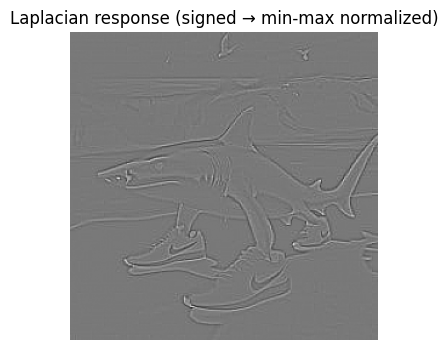

=== Sobel Vertical ===


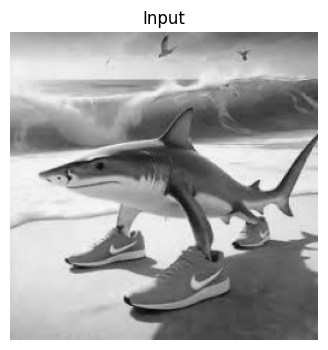

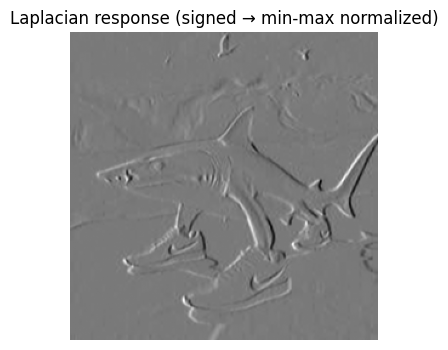

=== Sobel Horizontal ===


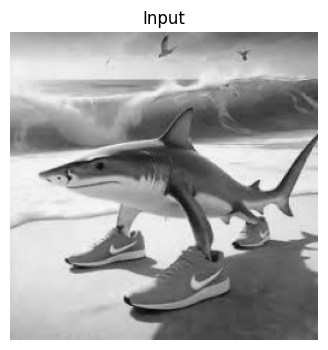

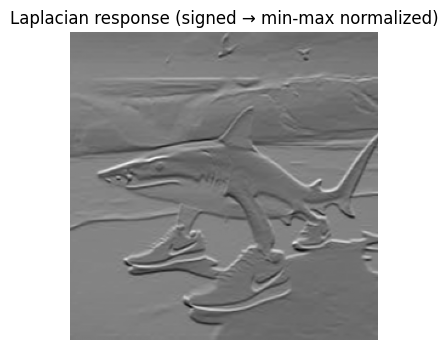

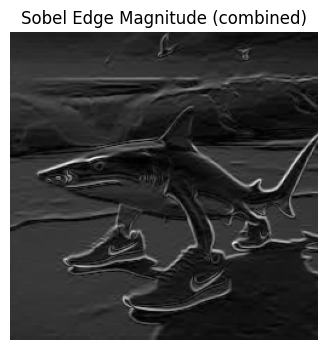

In [8]:
print('=== Laplacian ===')
resp_lp = apply_filter_and_visualize(img, laplace)

print('=== Sobel Vertical ===')
resp_sv = apply_filter_and_visualize(img, sobel_vertical)

print('=== Sobel Horizontal ===')
resp_sh = apply_filter_and_visualize(img, sobel_horizontal)

edge_mag = np.sqrt(resp_sv**2 + resp_sh**2)
edge_mag = minmax_norm(edge_mag)

show_gray(edge_mag, 'Sobel Edge Magnitude (combined)')

# Resnet18 구현하기

앞선 문제에서 Convolution 연산을 구현하여 보았으니,  
이번에는 **Resnet18을 직접 구현**해보고자 합니다.  
**Pytorch의 nn.Conv2d를 사용하시면 되지만**,  
본인이 구현한 Conv2d가 backward 연산이 가능하도록 설계되었다면 그것을 사용하여 구현하셔도 좋습니다.

**라이브러리 및 함수 정의**

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm

data_path = "/content/drive/MyDrive/DSL-2/[0902]CNN_FirstnameLASTNAME/Code assignment/Code assignment/data"

batch_size = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [10]:
def train(model, trainloader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=0.01,
        weight_decay=5e-4,
        momentum=0.9
    )
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(trainloader,desc=f'Epoch {epoch+1}/{epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(trainloader)}")

def test(model, testloader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

**Q1. CIFAR10 데이터셋을 분류하는 Resnet18 classifier를 구현하세요**

Input (Batch size x 3 x 32 x 32) / Output (Batch size x Num class)  
이미지 배치를 입력받아 label 개수에 맞는 logit을 반환하도록 BasicBlock과 ResNet18 class를 정의해주세요.  
**ImageNet(224x224)을 입력으로 받는 Original ResNet18과 달리 CIFAR10(32x32)을 입력으로 받으므로,**  
- **conv1과 conv2 layer의 filter size와, maxpooling, stride,**  
- **fc layer의 output dimension을 적절히 변형하셔야 합니다.**
- **ResNet의 Architecture는 아래와 같습니다**

![사진](./ResNet_Architectures.png)

In [11]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_ch, out_ch, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.downsample = None
        if stride != 1 or in_ch != out_ch:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(identity)
        out = F.relu(out + identity, inplace=True)
        return out

    ##############


class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        # CIFAR-10에 맞춘 stem (3x3 conv, stride=1, no maxpool)
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.in_ch = 64
        self.layer1 = self._make_layer(64,  2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)  # CIFAR-10 고정

    def _make_layer(self, out_ch, blocks, stride):
        layers = [BasicBlock(self.in_ch, out_ch, stride)]
        self.in_ch = out_ch
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_ch, out_ch, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x); x = self.layer2(x)
        x = self.layer3(x); x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        out = self.fc(x)
        return out

    ##################

모델이 안정적으로 학습되는지, 테스트 정확도가 잘 나오는지 (80% 이상) 확인해보세요

In [12]:
torch.manual_seed(42)
model = ResNet18().to(device)
train(model, trainloader, epochs=20)

Epoch 1/20: 100%|██████████| 500/500 [00:42<00:00, 11.63it/s]


Epoch 1/20, Loss: 1.2743845330476762


Epoch 2/20: 100%|██████████| 500/500 [00:42<00:00, 11.70it/s]


Epoch 2/20, Loss: 0.7515543972849846


Epoch 3/20: 100%|██████████| 500/500 [00:43<00:00, 11.43it/s]


Epoch 3/20, Loss: 0.5304313768744469


Epoch 4/20: 100%|██████████| 500/500 [00:43<00:00, 11.50it/s]


Epoch 4/20, Loss: 0.3869781192243099


Epoch 5/20: 100%|██████████| 500/500 [00:43<00:00, 11.47it/s]


Epoch 5/20, Loss: 0.28555208933353426


Epoch 6/20: 100%|██████████| 500/500 [00:43<00:00, 11.47it/s]


Epoch 6/20, Loss: 0.19360528662800788


Epoch 7/20: 100%|██████████| 500/500 [00:43<00:00, 11.46it/s]


Epoch 7/20, Loss: 0.1384392329454422


Epoch 8/20: 100%|██████████| 500/500 [00:43<00:00, 11.40it/s]


Epoch 8/20, Loss: 0.10142796263098716


Epoch 9/20: 100%|██████████| 500/500 [00:43<00:00, 11.46it/s]


Epoch 9/20, Loss: 0.08024315004050732


Epoch 10/20: 100%|██████████| 500/500 [00:43<00:00, 11.44it/s]


Epoch 10/20, Loss: 0.05863415074534714


Epoch 11/20: 100%|██████████| 500/500 [00:43<00:00, 11.41it/s]


Epoch 11/20, Loss: 0.03916189690958709


Epoch 12/20: 100%|██████████| 500/500 [00:43<00:00, 11.41it/s]


Epoch 12/20, Loss: 0.030701888509094714


Epoch 13/20: 100%|██████████| 500/500 [00:43<00:00, 11.46it/s]


Epoch 13/20, Loss: 0.03354908848321065


Epoch 14/20: 100%|██████████| 500/500 [00:43<00:00, 11.45it/s]


Epoch 14/20, Loss: 0.03386739215441048


Epoch 15/20: 100%|██████████| 500/500 [00:43<00:00, 11.43it/s]


Epoch 15/20, Loss: 0.025548194233793765


Epoch 16/20: 100%|██████████| 500/500 [00:44<00:00, 11.34it/s]


Epoch 16/20, Loss: 0.013558301303070038


Epoch 17/20: 100%|██████████| 500/500 [00:43<00:00, 11.42it/s]


Epoch 17/20, Loss: 0.007933807496214286


Epoch 18/20: 100%|██████████| 500/500 [00:43<00:00, 11.44it/s]


Epoch 18/20, Loss: 0.00290164885064587


Epoch 19/20: 100%|██████████| 500/500 [00:43<00:00, 11.45it/s]


Epoch 19/20, Loss: 0.001279610086872708


Epoch 20/20: 100%|██████████| 500/500 [00:43<00:00, 11.45it/s]

Epoch 20/20, Loss: 0.0007894424675323534


In [13]:
test(model, testloader, device)

Test Accuracy: 86.02%


86.02

**Q2. Original ResNet18과 CIFAR10 분류용으로 구현한 ResNet18의 차이점과 그렇게 수정한 이유를 아래 마크다운에 자세히 설명해주세요.**

입력 크기:

Original: 224×224 (ImageNet)

CIFAR-10: 32×32

Stem 부분:

Original: 7×7 conv (s=2) + 3×3 maxpool → 초반에 해상도 1/4로 축소

CIFAR-10: 3×3 conv (s=1), maxpool 제거 → 작은 입력에서 정보 손실 방지

다운샘플 경로:

동일하게 conv2_x~conv5_x 첫 블록에서 stride=2 사용

결과: CIFAR는 32→16→8→4, Original은 224→56→28→14→7

FC 레이어:

Original: 512→1000 클래스

CIFAR-10: 512→10 클래스


정리=>
1. 작은 입력(CIFAR-10) 에서는 큰 커널/초기 다운샘플을 줄이고(7×7→3×3, maxpool 제거),

2. 해상도를 더 오래 유지한 뒤 각 스테이지에서만 stride=2로 줄이며,

3. FC 출력만 클래스 수에 맞춰 변경
→ 세부 정보 보존, 연산·파라미터 감소, 수렴 안정성 및 정확도 개선을 노린 설계 변화